In [1]:
import numpy as np
from scipy.fft import rfft
from matplotlib.pylab import *
from scipy.io import wavfile
from scipy.signal import stft
from IPython.display import Audio

import matplotlib.pyplot as plt
from scipy.sparse import linalg
import scipy
from numpy import *
import glob

**KNOWN CODES**

In [2]:
# Function to generate Audio spectogram
def generate_audio_spectogram(audio_data,dft_size,overlap,window):
  '''
  audio_data : Input  sound data
  dft_size   : len of your Fourier transform
  overlap    : overlap btw of 2 dfts
  window     : Hanning window

  Returns magnitudes of a sound spectogram
  '''

  audio_len = len(audio_data)
  hop_size = dft_size-overlap
  step_size = dft_size - hop_size
  num_window_frames = math.floor((audio_len - hop_size)/(hop_size))
  # Construct the Fourier Matrix
  dft_matrixs = []
  freqs = np.arange(0,dft_size,1)
  for n in range(dft_size):
      p = np.exp((-1j*2*np.pi*freqs*n)/dft_size)/np.sqrt(dft_size)
      dft_matrixs.append(p)
  F = np.array(dft_matrixs)

  # Applying Hanning window
  FH = np.multiply(F,window)

  # initilaize the output vector
  output = np.zeros((num_window_frames,dft_size),dtype=complex)

  # loop over all dft windows
  for sub_win_index in range(0,num_window_frames):
    temp_data = audio_data[sub_win_index*hop_size:(sub_win_index*hop_size+dft_size)]
    if len(temp_data) != dft_size:
      break
    # Generate DFT for each window upon multiplying audio data with Fourier matrix
    output[sub_win_index,:] = np.matmul(FH,temp_data)

  nyxt_output = (output.T)[:int(dft_size/2),:]

  # Take magnitufe of the spectogram
  nyxt_magnitudes = np.log(np.abs(nyxt_output))

  return nyxt_magnitudes

# Function to Normalize the data
def normalize_data(nyxt_magnitudes):
  '''
  nyxt_magnitudes : magnitudes of spectogram

  Returns Normalized spectogram
  '''
  mean_values = np.mean(nyxt_magnitudes,axis = 1)
  # broadcast/repeat the mean values along the axis
  mean_values = (np.ones((nyxt_magnitudes.shape[1],1))*mean_values).transpose()

  std_values = np.std(nyxt_magnitudes,axis = 1)
  # broadcast/repeat the std values along the axis
  std_values = (np.ones((nyxt_magnitudes.shape[1],1))*std_values).transpose()

  nyxt_magnitudes_norm = (nyxt_magnitudes - mean_values)
  return nyxt_magnitudes_norm

def load_audio_data(file_path,custom = False):
  # Given input data
  dft_size = 1024
  overlap = dft_size//2  # 1/2 of overlapp
  window = np.hamming(dft_size)
  data = []

  if custom:
    sample_rate, audio_data = wavfile.read(file_path)
    # Generate spectogram
    nyxt_magnitudes = generate_audio_spectogram(audio_data,dft_size,overlap,window)
    # Normalize spectogram
    nyxt_magnitudes_norm = normalize_data(nyxt_magnitudes)
    data.append(nyxt_magnitudes_norm)
    return data,sample_rate

  for file in [file_path+str(i)+".wav" for i in range(1,61)]:
    sample_rate, audio_data = wavfile.read(file)
    # Generate spectogram
    nyxt_magnitudes = generate_audio_spectogram(audio_data,dft_size,overlap,window)
    # Normalize spectogram
    nyxt_magnitudes_norm = normalize_data(nyxt_magnitudes)
    data.append(nyxt_magnitudes_norm)
  return data,sample_rate

def merge_data(train_x1,train_x2,test_x1,test_x2):
  train_x1_array = np.concatenate(list(train_x1),axis = 1)
  train_x2_array = np.concatenate(list(train_x2),axis = 1)
  test_x1_array = np.concatenate(list(test_x1),axis = 1)
  test_x2_array = np.concatenate(list(test_x2),axis = 1)

  train_x = np.concatenate([train_x1_array,train_x2_array],axis =1)
  train_y = np.concatenate([np.array([0 for i in range(train_x1_array.shape[1])]),np.array([1 for i in range(train_x2_array.shape[1])])])
  test_x = np.concatenate([test_x1_array,test_x2_array],axis =1)
  test_y = np.concatenate([np.array([0 for i in range(test_x1_array.shape[1])]),np.array([1 for i in range(test_x2_array.shape[1])])])

  return train_x,train_y,test_x,test_y


def discriminant(x, mean, cov):
    return -0.5 * np.dot(np.dot(( x - mean), np.linalg.inv(cov)), ( x - mean).T) - 0.5 * np.log(np.linalg.det(cov))

def get_mean_cov_per_class(num_classes,reduced_train,train_labels):

  class_means = []
  class_covariance = []

  for i in range(num_classes):
      class_data = reduced_train[train_labels == i]
      class_means.append(np.mean(class_data, axis=0))
      class_covariance.append((class_data.T @ class_data)/class_data.T.shape[1])

  return class_means,class_covariance

def get_gaussian_predictions(num_classes,reduced_test,test_labels,class_means,class_covariance):

  predictions = []
  for i in range(len(test_labels)):
      discriminants = []
      for j in range(num_classes):
          disc_value = discriminant(reduced_test[i], class_means[j], class_covariance[j])
          discriminants.append(disc_value)
      predicted_class = np.argmax(discriminants)
      predictions.append(predicted_class)
  return predictions

In [3]:
import glob
import scipy.io.wavfile
from random import shuffle
from numpy.fft import rfft

# Define spectrogram representation
def spectrogram_features(x, size):

    # Get frames
    lenl = len(x)//size
    # print("no of values : ",len(x))
    # print("no of frames : ",lenl)
    x = reshape(x[:lenl*size], (lenl,-1)).T

    # Window and FFT them
    w = hanning(size)[:,None]
    FFT = rfft(w*x, axis=0)

    # Return log magnitude
    return log(abs(FFT) + 1e-8)


#using the same PCA function from my last assignment
def pca(data, num_eigen):

    mean = np.mean(data, axis=1, keepdims=True)

    # Remove mean from data before performing PCA
    mean_removed_data = data - mean

    # Get covariance estimate C(Z) = (Z.ZT) /n-1
    C = np.dot(mean_removed_data, np.transpose(mean_removed_data)) / (mean_removed_data.shape[1]-1)

    # Get top 3/k PCA covariance eigenvectors/values
    eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(C, k=num_eigen)

    #descending order of eigenvalues and vectors
    eigenvalues = eigenvalues[::-1]
    eigenvectors = eigenvectors[:,::-1]

    # Resulting transformation
    pcas = np.dot(diag(1.0/sqrt(eigenvalues)), np.transpose(eigenvectors))

    return pcas, mean


# gaussian_classifier for each class
def gaussian_classifier(x, gauss=None, diagonal=False):

    # If no model is provided, then train
    if gauss is None:

        # class mean
        mean = np.mean(x, axis=1, keepdims=True)
        # print("mean shape ", mean.shape )
        # class covariance
        covariance = ((x-mean) @ (x-mean).T) / (x.shape[1]-1)

        if diagonal:
            covariance = np.diag(np.diag(covariance))

        return {"mean": mean, "icov": np.linalg.inv(covariance)}

    # If a model is provided just compute log likelihoods
    else:
        mean = gauss["mean"]
        cov = gauss["icov"]
        # print("mean shape ", mean.shape )
        # print("cov shape ", cov.shape )
        # print("x shape ", x.shape )
        x_m = x - mean
        delta = sum(x_m * (cov @ x_m), axis=0)

        # Compute class likelihood P(x|ωi)
        return -.5*(-np.log(np.linalg.det(cov)) + delta + x.shape[0] * np.log(2 * np.pi))

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [5]:
directory = "/content/drive/MyDrive/"

In [6]:
mapp =  {"pop" : 0,
        "blues" : 1,
        "classical" : 2,
        "country" : 3,
        "disco" : 4,
        "hiphop" : 5,
        "jazz" : 6,
        "metal" : 7,
        "reggae" : 8,
        "rock" : 9
         }

In [24]:
from tqdm import tqdm

def read_data_by_class(target_class):
  size = 1024
  music = []
  print(target_class)
  for i in glob.glob(audio+ target_class+ '/' + target_class + '.*.wav'):
    try:
      file = scipy.io.wavfile.read(i)[1]
      log_mag = spectrogram_features(file, size)
      if log_mag.shape[1] != 630:
        log_mag = log_mag[:,:630]
      music.append(log_mag)

    except Exception as e:
      print(e)
  try:
    return np.array(music)
  except Exception as e:
    print(e)
    for m in tqdm(music):
      print(m.shape)
    return None

audio = directory+'genres_original/'

genres = [
              "pop",
              "blues",
              "classical",
              "country",
              "disco",
              "hiphop",
              "jazz",
              "metal",
              "reggae",
              "rock"
              ]

music_data = []
music_label = []

for genre in tqdm(genres):
  value = (read_data_by_class(genre))
  if value is None:
    break
  if len(value) != 99:
    value = value[:99]
  music_data.append(value)
  # print(music_data.shape)
  # break
  music_label.extend([mapp[genre] for _ in range(len(value))])


  0%|          | 0/10 [00:00<?, ?it/s]

pop


 10%|█         | 1/10 [00:02<00:26,  2.98s/it]

blues


 20%|██        | 2/10 [00:06<00:25,  3.24s/it]

classical


 30%|███       | 3/10 [00:08<00:20,  2.93s/it]

country


 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

disco


 50%|█████     | 5/10 [00:14<00:14,  2.80s/it]

hiphop


 60%|██████    | 6/10 [00:17<00:11,  2.97s/it]

jazz
File format b'\xcb\x15\x1e\x16' not understood. Only 'RIFF' and 'RIFX' supported.


 70%|███████   | 7/10 [00:21<00:09,  3.16s/it]

metal


 80%|████████  | 8/10 [00:23<00:06,  3.02s/it]

reggae


 90%|█████████ | 9/10 [00:26<00:02,  2.92s/it]

rock


100%|██████████| 10/10 [00:29<00:00,  2.96s/it]


In [25]:
new_music_data =  np.concatenate(music_data,axis = 0)
new_music_data.shape

(990, 513, 630)

In [26]:
new_music_label = np.array(music_label)
new_music_label.shape

(990,)

Future Work regarding feature extraction

In [27]:
import librosa

In [28]:
for i in range(len(new_music_label)):
  x = new_music_data[i,:,:]
  feat_label = []

  # Zero Crossing
  n0 = 9000
  n1 = 9100
  zero_crossings = librosa.zero_crossings(x, pad=False)
  #print(zero_crossings)
  #zero_crossings = np.where(zero_crossing[])
  feat_label.append(zero_crossings)

  # Spectral Centroid
  spectral_centroids = librosa.feature.spectral_centroid(y = x, sr = 22050)[0]
  feat_label.append(spectral_centroids)
  print('spectral_centroids')
  #print(spectral_centroids)

  # Spectral Rolloff
  spectral_rolloff = librosa.feature.spectral_rolloff(y = x, sr = 22050)[0]
  feat_label.append(spectral_rolloff)
  #2print('spectral_rolloff')
  print(spectral_rolloff)

  # MFCC
  mfccs = librosa.feature.mfcc(y = x, sr = 22050)
  feat_label.append(mfccs)
  #print('mfccs')
  #print(mfccs)

print(feat_label)

spectral_centroids
[[7719.65332031 7579.6875    ]]
spectral_centroids
[[7332.05566406 7439.72167969]]
spectral_centroids
[[7407.421875   7762.71972656]]
spectral_centroids
[[7579.6875     7611.98730469]]
spectral_centroids
[[7450.48828125 7364.35546875]]
spectral_centroids
[[7105.95703125 7342.82226562]]
spectral_centroids
[[7364.35546875 7482.78808594]]
spectral_centroids
[[7568.92089844 7665.8203125 ]]
spectral_centroids
[[7019.82421875 6998.29101562]]
spectral_centroids
[[7687.35351562 7504.32128906]]
spectral_centroids
[[6804.4921875  7052.12402344]]
spectral_centroids
[[7482.78808594 7504.32128906]]
spectral_centroids
[[7127.49023438 7536.62109375]]
spectral_centroids
[[7418.18847656 7332.05566406]]
spectral_centroids
[[7482.78808594 7482.78808594]]
spectral_centroids
[[4737.3046875  4715.77148438]]
spectral_centroids
[[7536.62109375 7859.61914062]]
spectral_centroids
[[7396.65527344 7547.38769531]]
spectral_centroids


KeyboardInterrupt: ignored

In [14]:
print(feat_label)

[array([], shape=(0, 630), dtype=bool), array([[2948.75216795, 2967.44499055]]), array([[7590.45410156, 7676.58691406]]), array([[[225.95320868, 238.08832286],
        [ 53.84239813,  54.14978462],
        [ 31.39538663,  30.90999739],
        ...,
        [ 10.85613112,  11.80353872],
        [  6.8521644 ,   3.13313487],
        [  2.98766929,   2.52526731]],

       [[212.13632643, 226.01807901],
        [ 74.50038639,  77.09596793],
        [ 31.34322016,  32.41716091],
        ...,
        [  5.3422523 ,   2.97620852],
        [  6.76347735,   6.07603342],
        [  0.25953083,  -0.84933416]],

       [[217.93715189, 231.273284  ],
        [ 84.56705095,  85.08394207],
        [ 29.02287538,  29.95913033],
        ...,
        [  4.40373352,   6.39002487],
        [  3.83038726,   2.89180973],
        [  1.05511695,   2.29141718]],

       ...,

       [[141.29724333, 154.50508028],
        [ 25.6981067 ,  19.30025047],
        [ 24.62413266,  19.54293883],
        ...,
        [

Future Work regarding feature extraction

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(new_music_data, new_music_label, stratify=new_music_label, test_size=0.2, random_state=0)

In [ ]:
del new_music_data
del new_music_label

In [ ]:
del music_data
del music_label

In [ ]:
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

# x_train = x_train.reshape(-1, 513, 630, 1)
# dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

batch_size = 32
# prefetch_size = tf.data.experimental.AUTOTUNE
# dataset = dataset.batch(batch_size).prefetch(prefetch_size)

input_shape = (513, 630, 1)
num_classes = 10

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()





Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 511, 628, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 255, 314, 32)      0         
 g2D)                                                            
                                                                 
 batch_normalization_1 (Bat  (None, 255, 314, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_3 (Conv2D)           (None, 253, 312, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 126, 156, 64)      0         
 g2D)                                                            
                                                      

In [ ]:
epochs = 15
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=10)

Epoch 1/10
25/25 [==============================] - 34s 780ms/step - loss: 112.9555 - accuracy: 0.1250 - val_loss: 133.1541 - val_accuracy: 0.1010
Epoch 2/10
25/25 [==============================] - 15s 588ms/step - loss: 9.3807 - accuracy: 0.2626 - val_loss: 14.6240 - val_accuracy: 0.2020
Epoch 3/10
25/25 [==============================] - 14s 575ms/step - loss: 2.0787 - accuracy: 0.4596 - val_loss: 17.4605 - val_accuracy: 0.1768
Epoch 4/10
25/25 [==============================] - 15s 582ms/step - loss: 0.9402 - accuracy: 0.6793 - val_loss: 6.5120 - val_accuracy: 0.1970
Epoch 5/10
25/25 [==============================] - 14s 575ms/step - loss: 0.4502 - accuracy: 0.8864 - val_loss: 4.9482 - val_accuracy: 0.2374
Epoch 6/10
25/25 [==============================] - 15s 582ms/step - loss: 0.3042 - accuracy: 0.9419 - val_loss: 5.0598 - val_accuracy: 0.2374
Epoch 7/10
25/25 [==============================] - 15s 585ms/step - loss: 0.2037 - accuracy: 0.9672 - val_loss: 2.8985 - val_accuracy: 

In [ ]:
model.save('cnn_mlsp_val_44.keras')


In [ ]:
predicted_y = model.predict(x_test)

7/7 [==============================] - 1s 65ms/step


In [ ]:
outputs = np.argmax(predicted_y,axis = 1)

Frame-level Accuracy 43.93939393939394


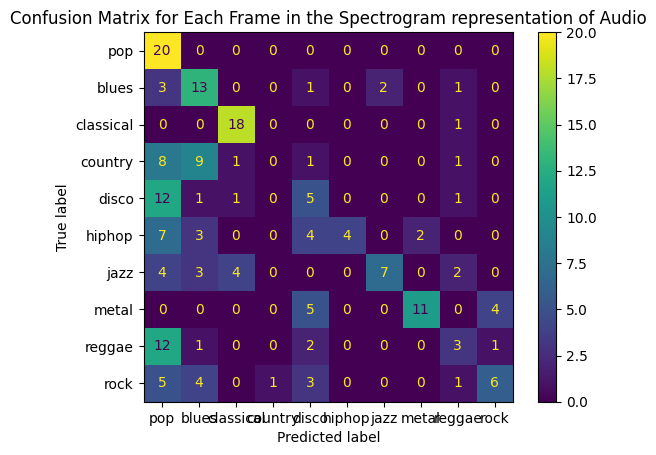

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix using testing data
conf_mat = confusion_matrix(y_test, outputs)

#frame-level accuracy
print("Frame-level Accuracy", 100*trace(conf_mat)/len(y_test))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=genres)
disp.plot()
plt.title("Confusion Matrix for Each Frame in the Spectrogram representation of Audio")
plt.show()

In [ ]:
# Epoch 1/10
# 25/25 [==============================] - 18s 626ms/step - loss: 127.4574 - accuracy: 0.0808 - val_loss: 43.1693 - val_accuracy: 0.1465
# Epoch 2/10
# 25/25 [==============================] - 15s 588ms/step - loss: 4.9002 - accuracy: 0.2374 - val_loss: 10.1279 - val_accuracy: 0.1869
# Epoch 3/10
# 25/25 [==============================] - 14s 577ms/step - loss: 1.8108 - accuracy: 0.4141 - val_loss: 7.4725 - val_accuracy: 0.1869
# Epoch 4/10
# 25/25 [==============================] - 14s 573ms/step - loss: 2.9530 - accuracy: 0.5354 - val_loss: 6.5535 - val_accuracy: 0.1566
# Epoch 5/10
# 25/25 [==============================] - 14s 570ms/step - loss: 1.5002 - accuracy: 0.5808 - val_loss: 4.2897 - val_accuracy: 0.1515
# Epoch 6/10
# 25/25 [==============================] - 14s 580ms/step - loss: 0.8986 - accuracy: 0.7058 - val_loss: 2.8041 - val_accuracy: 0.2071
# Epoch 7/10
# 25/25 [==============================] - 15s 581ms/step - loss: 0.6152 - accuracy: 0.8624 - val_loss: 2.0660 - val_accuracy: 0.3737
# Epoch 8/10
# 25/25 [==============================] - 15s 583ms/step - loss: 0.4096 - accuracy: 0.9369 - val_loss: 2.0535 - val_accuracy: 0.3838
# Epoch 9/10
# 25/25 [==============================] - 14s 575ms/step - loss: 0.3365 - accuracy: 0.9444 - val_loss: 2.4051 - val_accuracy: 0.3990
# Epoch 10/10
# 25/25 [==============================] - 15s 584ms/step - loss: 0.2128 - accuracy: 0.9823 - val_loss: 1.7773 - val_accuracy: 0.4545



In [ ]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=20)

Epoch 1/20
25/25 [==============================] - 15s 583ms/step - loss: 2.4836 - accuracy: 0.1086 - val_loss: 2.5206 - val_accuracy: 0.0808
Epoch 2/20
25/25 [==============================] - 15s 586ms/step - loss: 2.3055 - accuracy: 0.2121 - val_loss: 5.1607 - val_accuracy: 0.1414
Epoch 3/20
25/25 [==============================] - 15s 584ms/step - loss: 2.1644 - accuracy: 0.2260 - val_loss: 2.5530 - val_accuracy: 0.1818
Epoch 4/20
25/25 [==============================] - 15s 589ms/step - loss: 2.0127 - accuracy: 0.2563 - val_loss: 2.7818 - val_accuracy: 0.0859
Epoch 5/20
25/25 [==============================] - 15s 582ms/step - loss: 1.9894 - accuracy: 0.2702 - val_loss: 2.3578 - val_accuracy: 0.2121
Epoch 6/20
25/25 [==============================] - 15s 587ms/step - loss: 2.0979 - accuracy: 0.2778 - val_loss: 2.3751 - val_accuracy: 0.2828
Epoch 7/20
25/25 [==============================] - 15s 588ms/step - loss: 1.9383 - accuracy: 0.3119 - val_loss: 2.3140 - val_accuracy: 0.2071